In [4]:
# --- 1. 라이브러리 및 모듈 임포트 ---

# 데이터 처리 라이브러리
import pandas as pd
import numpy as np

# 데이터 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝 모델 및 평가 도구
import lightgbm as lgb
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
import joblib

# 변수 중요도 확인 및 모델 해석
import eli5
from eli5.sklearn import PermutationImportance

# 시스템 및 경로 관련 라이브러리
import sys
import os
from datetime import datetime
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

import matplotlib.font_manager as fm

try:
    fe = fm.FontEntry(
        fname=r'../../font/NanumFont/NanumGothic.ttf',
        name='NanumGothic')
    fm.fontManager.ttflist.insert(0, fe)
    plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})
    plt.rc('font', family='NanumGothic')
    
except FileNotFoundError:
    print("나눔고딕 폰트를 찾을 수 없어 기본 폰트로 설정됩니다.")
    pass

In [5]:
# --- 2. 경로 설정 및 커스텀 로거 임포트 ---

try:
    # 현재 노트북 파일의 위치를 기준으로 프로젝트 루트 경로를 설정합니다.
    src_path = os.path.abspath(os.path.join(os.getcwd(), "../../src/log"))
    sys.path.insert(0, src_path)
    from logger import Logger
    print("Logger 모듈 로드 성공.")
    
except ImportError:
    print("[오류] Logger 모듈을 찾을 수 없습니다. src/log/logger.py 경로를 확인해주세요.")
    # Logger가 없어도 코드가 중단되지 않도록 임시 클래스 정의
    class Logger:
        def __init__(self, *args, **kwargs): pass
        def write(self, message, **kwargs): print(message)

Logger 모듈 로드 성공.


In [ ]:
# --- 3. 로거 및 경로 초기화 ---

# 로그 파일이 저장될 경로 설정
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
LOG_DIR         = '../../data/logs/price_prediction_logs'
LOG_FILENAME    = f"price_prediction_{timestamp}.log"
LOG_PATH        = os.path.join(LOG_DIR, LOG_FILENAME)

# Directory 생성
os.makedirs(LOG_DIR, exist_ok=True)

# Logger 인스턴스 생성
logger = Logger(log_path=LOG_PATH)

# 데이터 및 제출 파일 경로 설정
SUBMISSION_DIR = '../../data/processed/submissions'
SUBMISSION_FILENAME = 'price_prediction_submission.csv'
SUBMISSION_PATH = os.path.join(SUBMISSION_DIR, SUBMISSION_FILENAME)

# model 저장 경로 설정
MODEL_DIR = '../../model'
MODEL_FILENAME = 'final_price_model.pkl'
MODEL_PATH = os.path.join(MODEL_DIR, MODEL_FILENAME)

logger.write("="*50)
logger.write(">> 아파트 가격 예측 모델링 시작")

2025-07-15 20:28:29 | ==================================================
2025-07-15 20:28:29 | >> 아파트 가격 예측 모델링 시작


In [7]:
# --- 4. 데이터 로드 (공통) ---

logger.write(">> 정제된 Train/Test 데이터를 로드합니다...")

try:
    # 학습 데이터와 테스트 데이터를 각각 로드
    train_df_clean = pd.read_csv('../../data/processed/cleaned_data/train_clean.csv')
    test_df_clean = pd.read_csv('../../data/processed/cleaned_data/test_clean.csv')
    logger.write(">> Train/Test 데이터 로드 완료.")
    
    # 두 데이터를 합치기 전에 isTest 컬럼으로 구분
    train_df_clean['isTest'] = 0
    test_df_clean['isTest'] = 1
    
    # 하나의 데이터프레임으로 합침
    df = pd.concat([train_df_clean, test_df_clean])
    
    logger.write(">> 데이터 로드 및 병합 완료.")
    
except FileNotFoundError:
    logger.write(f">> [오류] train_clean.csv 또는 test_clean.csv 파일을 찾을 수 없습니다.", print_error=True)
    df = None

2025-07-15 20:28:29 | >> 정제된 Train/Test 데이터를 로드합니다...
2025-07-15 20:28:31 | >> Train/Test 데이터 로드 완료.
2025-07-15 20:28:31 | >> 데이터 로드 및 병합 완료.


2025-07-15 20:28:31 | >> EDA: 데이터 정보 및 통계 요약을 시작합니다...
2025-07-15 20:28:31 | >> EDA: 데이터 정보 및 통계 요약
2025-07-15 20:28:31 | 데이터 크기: (1119373, 30)
2025-07-15 20:28:31 | 컬럼 목록: ['계약일자', '계약년월', '계약년도', '계약월', '자치구', '법정동', '강남3구여부', '전용면적', '층', '홈페이지유무', '사용허가여부', '연식', '브랜드등급', '아파트이름길이', '지하철최단거리', '반경_1km_지하철역_수', '반경_500m_지하철역_수', '반경_300m_지하철역_수', '버스최단거리', '반경_1km_버스정류장_수', '반경_500m_버스정류장_수', '반경_300m_버스정류장_수', '총인구수', '성비(남/여)', 'loanrate_1m', 'loanrate_3m', 'loanrate_6m', 'loanrate_12m', 'target', 'isTest']
2025-07-15 20:28:31 | 데이터 타입:
계약일자                object
계약년월                 int64
계약년도                 int64
계약월                  int64
자치구                 object
법정동                 object
강남3구여부               int64
전용면적               float64
층                    int64
홈페이지유무               int64
사용허가여부               int64
연식                   int64
브랜드등급               object
아파트이름길이              int64
지하철최단거리            float64
반경_1km_지하철역_수        int64
반경_500m_지하철역_수      

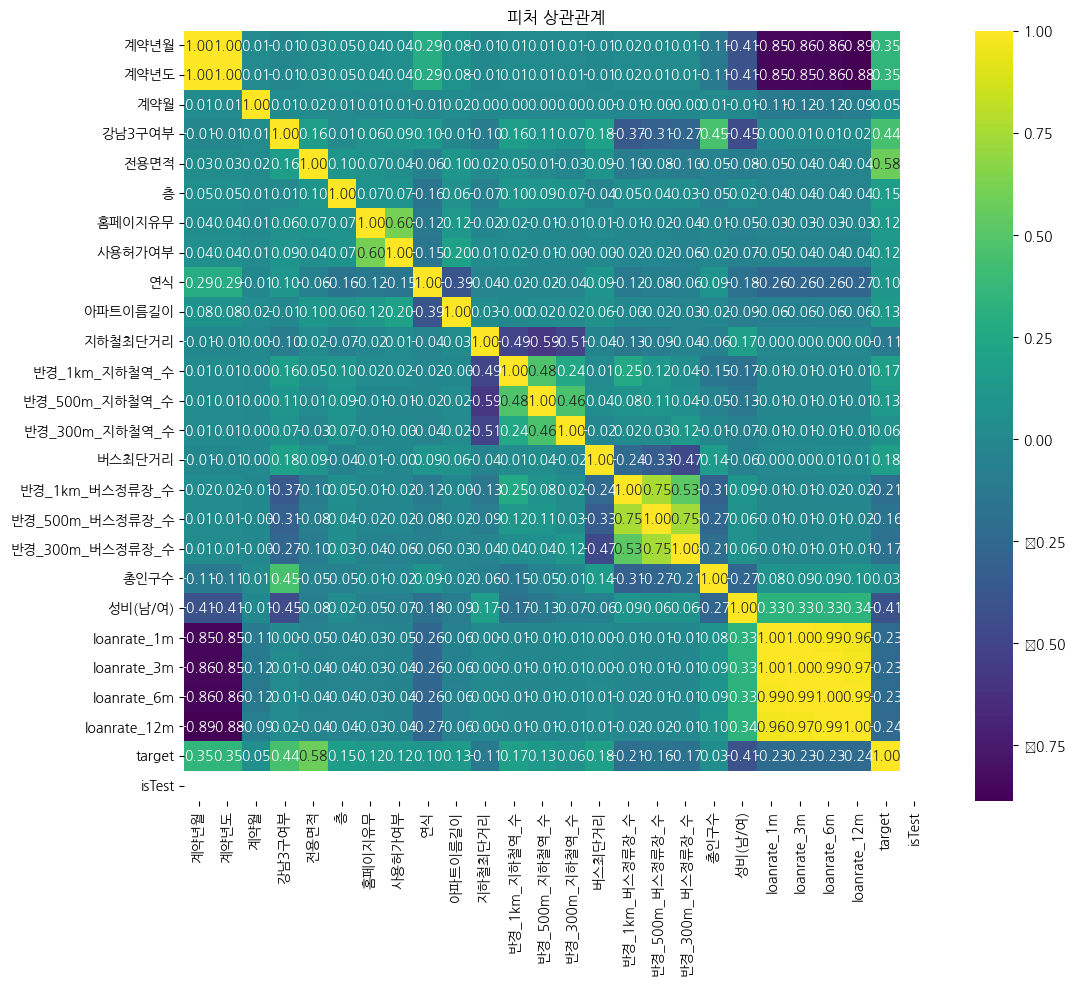

2025-07-15 20:28:33 | >> EDA: 전용면적 vs 가격 산점도 시각화


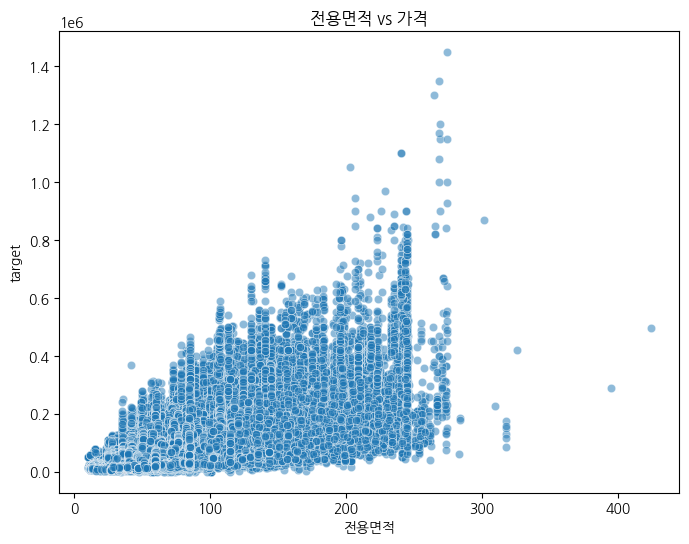

2025-07-15 20:28:34 | >> EDA: 주요 변수 데이터 분포 시각화


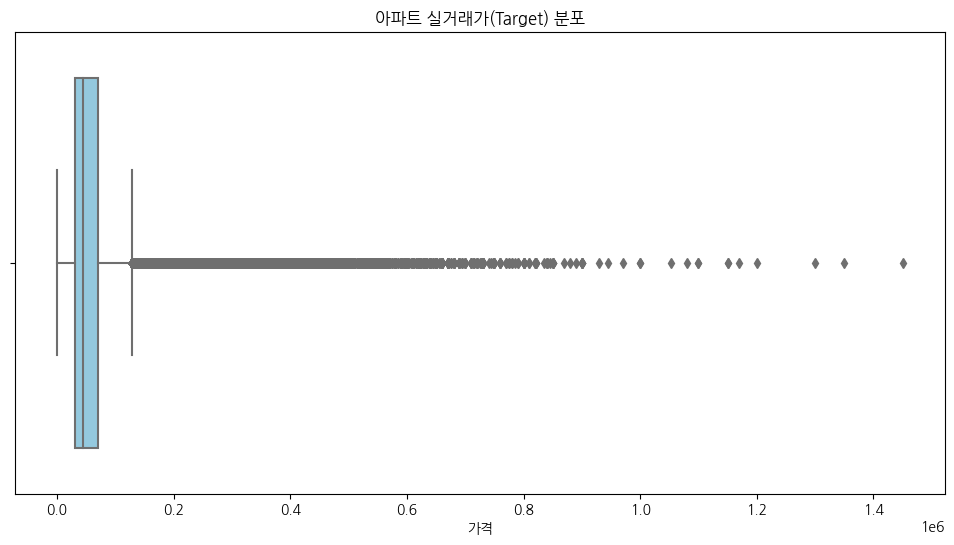

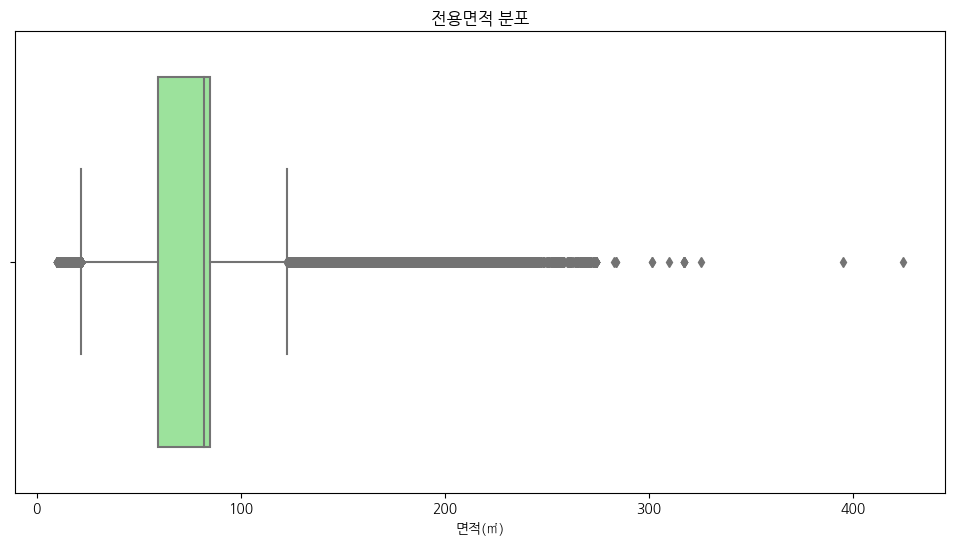

2025-07-15 20:28:35 | >> EDA 완료


In [8]:
# --- 5. EDA (탐색적 데이터 분석) ---

logger.write(">> EDA: 데이터 정보 및 통계 요약을 시작합니다...")

if df is not None:
    # 데이터 정보 및 통계 요약 로그 기록
    logger.write(">> EDA: 데이터 정보 및 통계 요약")
    logger.write(f"데이터 크기: {df.shape}")
    logger.write(f"컬럼 목록: {df.columns.tolist()}")
    logger.write(f"데이터 타입:\n{df.dtypes}")
    stats = df.describe()
    logger.write(f"\n통계 요약:\n{stats}")

if train_df_clean is not None:
    # 상관관계 히트맵
    logger.write(">> EDA: 상관관계 히트맵 시각화")
    plt.figure(figsize=(12, 10))
    sns.heatmap(train_df_clean.corr(), annot=True, fmt=".2f", cmap='viridis')
    plt.title('피처 상관관계')
    plt.show()

    # 전용면적 vs 가격 산점도
    logger.write(">> EDA: 전용면적 vs 가격 산점도 시각화")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='전용면적', y='target', data=train_df_clean, alpha=0.5)
    plt.title('전용면적 vs 가격')
    plt.show()

    # 주요 변수 데이터 분포 시각화
    logger.write(">> EDA: 주요 변수 데이터 분포 시각화")
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=train_df_clean, x='target', color='skyblue')
    plt.title('아파트 실거래가(Target) 분포')
    plt.xlabel('가격')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='전용면적', color='lightgreen')
    plt.title('전용면적 분포')
    plt.xlabel('면적(㎡)')
    plt.show()
    logger.write(">> EDA 완료")

In [9]:
# --- 6. 피처 엔지니어링 (수정 및 강화) ---

# 계약일자 관련 파생변수 생성
def create_date_features(df):
    df['계약일자'] = pd.to_datetime(df['계약일자'])
    df['계약년'] = df['계약일자'].dt.year
    df['계약월'] = df['계약일자'].dt.month
    df['계약분기'] = df['계약일자'].dt.quarter
    df.drop(columns=['계약일자'], inplace=True)
    return df

train_df_clean = create_date_features(train_df_clean)
test_df_clean = create_date_features(test_df_clean)


# 기타 파생변수 생성
def create_other_features(df):
    df['신축여부'] = (df['연식'] <= 10).astype(int)
    
    traffic_cols = [
        '지하철최단거리', '반경_1km_지하철역_수', '반경_500m_지하철역_수', '반경_300m_지하철역_수',
        '버스최단거리', '반경_1km_버스정류장_수', '반경_500m_버스정류장_수', '반경_300m_버스정류장_수'
    ]
    for col in traffic_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    return df

train_df_clean = create_other_features(train_df_clean)
test_df_clean = create_other_features(test_df_clean)

# --- 💡 데이터 누수(Data Leakage)를 방지하는 통계 피처 생성 ---
# 학습 데이터(train_df_clean)에서만 통계량을 계산하고, 테스트 데이터에 병합합니다.
# 이렇게 하면 테스트 데이터의 정보가 학습에 사용되는 것을 막을 수 있습니다.

# 자치구별 평균 가격 및 거래량
sigungu_stats = train_df_clean.groupby('자치구')['target'].agg(['mean', 'count']).reset_index()
sigungu_stats.columns = ['자치구', '자치구별_평균가격', '자치구별_거래량']

# 학습 및 테스트 데이터에 통계 피처 병합
train_df_clean = pd.merge(train_df_clean, sigungu_stats, on='자치구', how='left')
test_df_clean = pd.merge(test_df_clean, sigungu_stats, on='자치구', how='left')

# 테스트 데이터에만 존재할 수 있는 '자치구'의 NA 값 처리
test_df_clean.fillna(train_df_clean.mean(numeric_only=True), inplace=True)

In [10]:
# --- 6-1. 고급 특성 공학 추가 ---

if df is not None:
    try:
        logger.write(">> 고급 특성 공학을 시작합니다...")

        # 위치(자치구) 기반 통계 특성 생성
        sigungu_stats = df.groupby('자치구')['target'].agg(['mean','std','count']).reset_index()
        sigungu_stats.columns = ['자치구','자치구별_평균가격','자치구별_가격편차','자치구별_거래량']
        df = pd.merge(df, sigungu_stats, on='자치구', how='left')

        # NA값 채우기 (테스트 데이터에만 존재할 수 있는 자치구 처리)
        df['자치구별_가격편차'].fillna(0, inplace=True)
        # 훈련 데이터 전체 평균으로 NA 값 채우기
        mean_price = df['자치구별_평균가격'].mean()
        df['자치구별_평균가격'].fillna(mean_price, inplace=True)
        mean_volume = df['자치구별_거래량'].mean()
        df['자치구별_거래량'].fillna(mean_volume, inplace=True)


        # 상호작용 특성 생성
        df['면적_x_연식'] = df['전용면적'] * df['연식']
        df['면적_x_층'] = df['전용면적'] * df['층']

        logger.write(">> 고급 특성 공학 완료.")
        logger.write(f">> 추가된 컬럼: {['자치구별_평균가격', '자치구별_가격편차', '자치구별_거래량', '면적_x_연식', '면적_x_층']}")

    except Exception as e:
        logger.write(f">> [오류] 고급 특성 공학 중 문제 발생: {e}", print_error=True)

2025-07-15 20:28:35 | >> 고급 특성 공학을 시작합니다...
2025-07-15 20:28:36 | >> 고급 특성 공학 완료.
2025-07-15 20:28:36 | >> 추가된 컬럼: ['자치구별_평균가격', '자치구별_가격편차', '자치구별_거래량', '면적_x_연식', '면적_x_층']


In [11]:
# --- 7. 피처 선택 및 데이터 분리 (공통) ---

logger.write(">> 피처 선택 및 데이터 분리를 시작합니다...")

if df is not None:
    try:
        # 1. Train/Test 데이터 분리
        train_df = df[df['isTest']==0].drop('isTest',axis=1).copy()
        test_df  = df[df['isTest']==1].drop('isTest',axis=1).copy()
        logger.write(">> Train/Test 데이터 분리 완료.")

        # 2. (✨✨핵심 수정✨✨) X,y 분리 전, train_df의 결측치/무한대 값 처리
        # 이 작업을 통해 피처와 타겟의 샘플 수가 완벽하게 일치하게 됩니다.
        initial_rows = len(train_df)
        train_df.replace([np.inf, -np.inf], np.nan, inplace=True) # 무한대 값을 NaN으로 변경
        train_df.dropna(inplace=True) # NaN이 포함된 행 전체 제거
        logger.write(f">> train_df 정제 완료: {initial_rows - len(train_df)}개 행 제거됨. 최종 {len(train_df)}개 행 사용.")

        # 테스트 데이터의 결측치는 예측을 위해 특정 값으로 채우는 것이 일반적입니다.
        test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        test_df.fillna(0, inplace=True) # 0으로 채우거나 다른 전략 사용 가능

        # 3. 정제된 데이터프레임에서 피처(X)와 타겟(y) 최종 정의
        features = [col for col in train_df.columns if col not in ['target', 'id', '아파트이름']]

        # 4) 학습용·예측용 데이터 준비
        X_train_raw = train_df[features]
        y_train     = train_df['target'] # 정제된 train_df에서 생성하므로 행의 개수가 일치함
        X_test_raw  = test_df[features]

        # 5) 범주형 피처 자동 탐지
        categorical_features = X_train_raw.select_dtypes(include=['object']).columns.tolist()
        
        logger.write(f">> 예측에 사용할 피처 개수: {len(features)}개")
        logger.write(f">> 범주형 피처: {categorical_features}")

    except Exception as e:
        logger.write(f">> [오류] 피처 선택 및 데이터 분리 중 문제 발생: {e}", print_error=True)

2025-07-15 20:28:36 | >> 피처 선택 및 데이터 분리를 시작합니다...
2025-07-15 20:28:36 | >> Train/Test 데이터 분리 완료.
2025-07-15 20:28:37 | >> train_df 정제 완료: 0개 행 제거됨. 최종 1110101개 행 사용.
2025-07-15 20:28:37 | >> 예측에 사용할 피처 개수: 33개
2025-07-15 20:28:37 | >> 범주형 피처: ['계약일자', '자치구', '법정동', '브랜드등급']


In [12]:
# --- 8. 범주형 피처 Label Encoding (price_prediction2.ipynb 방식으로 강화) ---

if 'X_train_raw' in locals():
    try:
        label_encoders = {}
        for col in categorical_features:
            le = LabelEncoder()
            # Train과 Test 데이터 전체의 값을 사용하여 fit
            all_vals = pd.concat([X_train_raw[col], X_test_raw[col]]).astype(str).unique()
            le.fit(all_vals)
            X_train_raw[col] = le.transform(X_train_raw[col].astype(str))
            X_test_raw[col]  = le.transform(X_test_raw[col].astype(str))
            label_encoders[col] = le
            
        logger.write(">> 범주형 Label Encoding 완료.")
        
    except Exception as e:
        logger.write(f">> [오류] Label Encoding 중 문제 발생: {e}", print_error=True)

2025-07-15 20:28:37 | >> 범주형 Label Encoding 완료.


2025-07-15 20:28:37 | >> 표준 출력 및 오류를 로그 파일로 리디렉션 시작
2025-07-15 20:28:38 | >> LightGBM 모델 학습 시작
2025-07-15 20:28:38 | [LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
2025-07-15 20:28:38 | [LightGBM] [Info] Total Bins 3636
2025-07-15 20:28:38 | [LightGBM] [Info] Number of data points in the train set: 888080, number of used features: 33
2025-07-15 20:28:38 | [LightGBM] [Info] Start training from score 57976.164328
2025-07-15 20:28:39 | >> 모델 학습 완료. Validation RMSE: 12016.4981, MAE: 7343.8524, R2: 0.9334


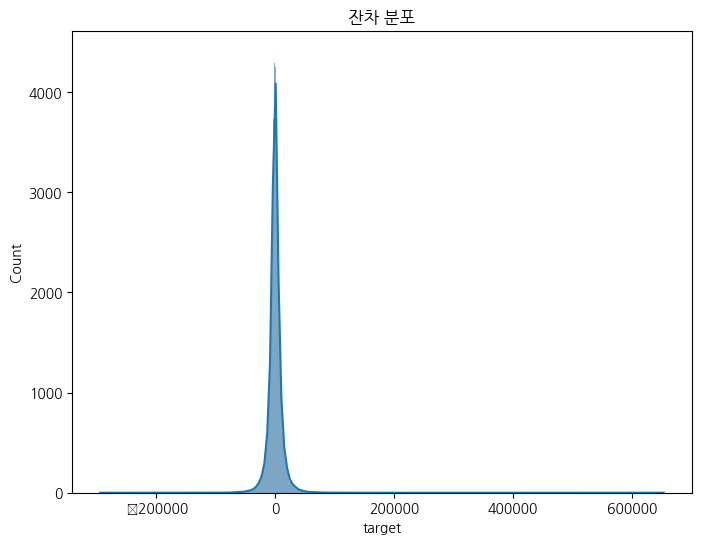

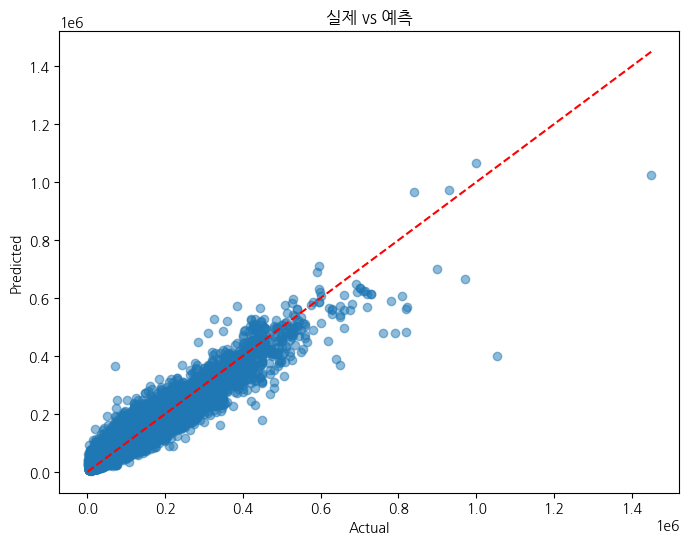

2025-07-15 20:28:41 | >> 표준 출력 및 오류 리디렉션 중지


In [13]:
# --- 9. 모델 학습 및 기본 평가  ---

if 'X_train_raw' in locals():
    # 표준 출력을 로그 파일로 리디렉션 시작
    logger.start_redirect()
    
    try:
        X_train, X_val, y_train_split, y_val_split = train_test_split(
            X_train_raw, y_train, test_size=0.2, random_state=42
        )

        logger.write(">> LightGBM 모델 학습 시작")
        lgbm = lgb.LGBMRegressor(device='cuda', random_state=42)
        lgbm.fit(X_train, y_train_split)
        y_pred = lgbm.predict(X_val)

        # price_prediction2.ipynb의 다양한 평가지표 추가
        rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))
        mae  = mean_absolute_error(y_val_split, y_pred)
        r2   = r2_score(y_val_split, y_pred)
        logger.write(f">> 모델 학습 완료. Validation RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

        # 잔차 분포 시각화 (price_prediction2.ipynb에서 추가)
        residuals = y_val_split - y_pred
        plt.figure(figsize=(8,6))
        sns.histplot(residuals, kde=True)
        plt.title('잔차 분포')
        plt.show()

        # 실제 vs 예측 산점도 (price_prediction2.ipynb에서 추가)
        plt.figure(figsize=(8,6))
        plt.scatter(y_val_split, y_pred, alpha=0.5)
        plt.plot([y_val_split.min(), y_val_split.max()],
                 [y_val_split.min(), y_val_split.max()],
                 'r--')
        plt.title('실제 vs 예측')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.show()

    except Exception as e:
        logger.write(f">> [오류] 모델 학습/평가 중 문제 발생: {e}", print_error=True)
        
    finally:
        # 표준 출력을 원래대로 복구
        logger.stop_redirect()

2025-07-15 20:28:41 | >> Permutation Importance를 계산합니다...
2025-07-15 20:28:52 | >> Permutation Importance 계산 완료.


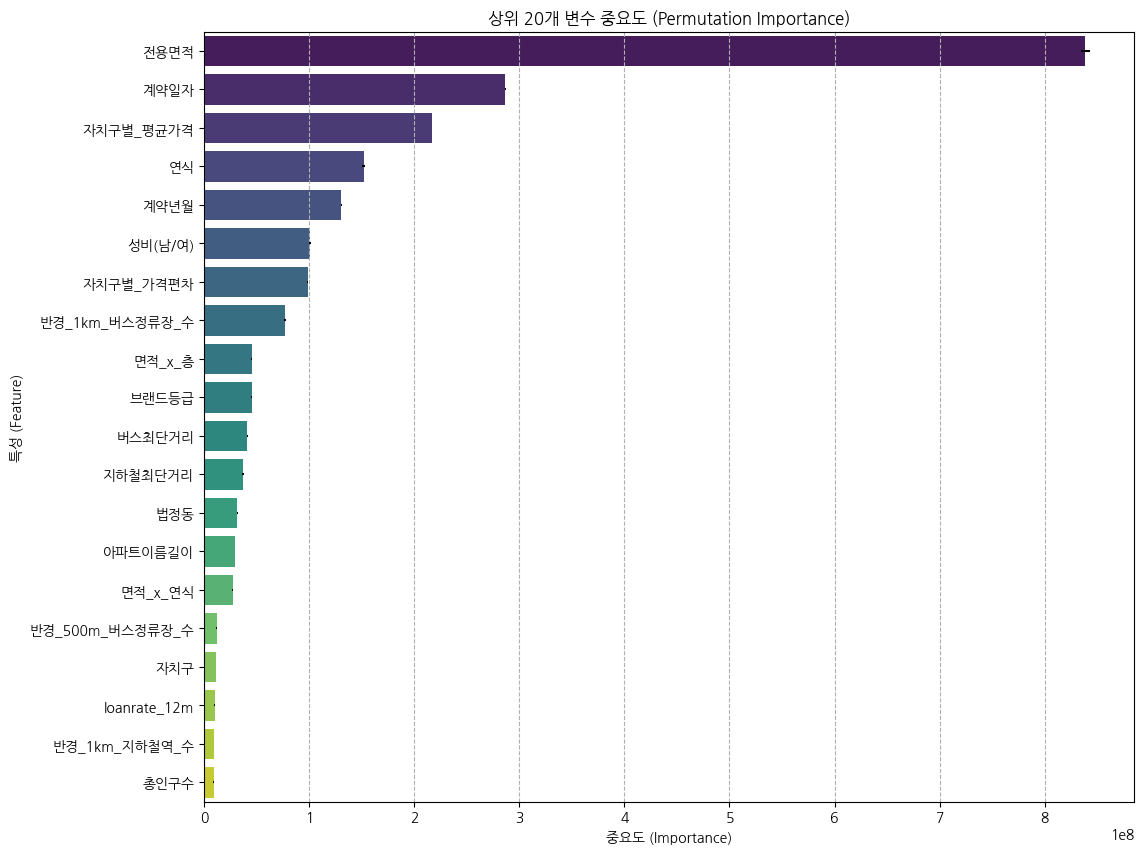

In [14]:
# --- 10. 변수 중요도 분석 (Permutation Importance) (price_prediction.ipynb 내용 유지) ---

if 'X_val' in locals():
    logger.write(">> Permutation Importance를 계산합니다...")
    perm = PermutationImportance(lgbm, scoring='neg_mean_squared_error', random_state=42, n_iter=3).fit(X_val, y_val_split)
    logger.write(">> Permutation Importance 계산 완료.")
        
    importance_df = pd.DataFrame({
        'feature': X_val.columns,
        'importance': perm.feature_importances_,
        'std': perm.feature_importances_std_
    }).sort_values(by='importance', ascending=False)
        
    top_n = 20
    plt.figure(figsize=(12, 10))
    sns.barplot(
        x='importance', 
        y='feature', 
        data=importance_df.head(top_n), 
        xerr=importance_df.head(top_n)['std'],
        palette='viridis'
    )
    plt.title(f'상위 {top_n}개 변수 중요도 (Permutation Importance)')
    plt.xlabel('중요도 (Importance)')
    plt.ylabel('특성 (Feature)')
    plt.grid(True, axis='x', linestyle='--')
    plt.show()

2025-07-15 20:28:53 | >> 예측 오차 분석을 시작합니다...


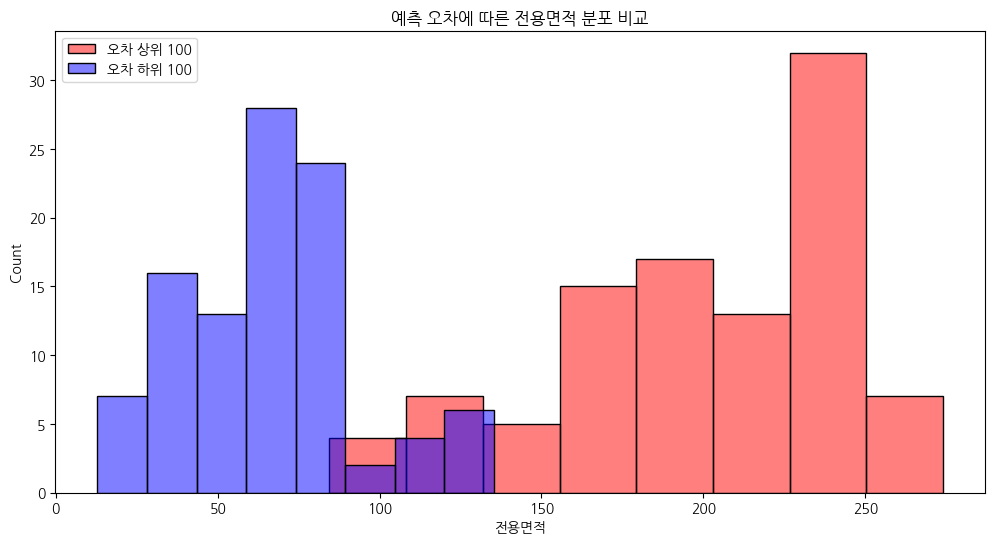

In [15]:
# --- 11. 예측 오차 분석 (price_prediction.ipynb 내용 유지) ---

if 'X_val' in locals():
    logger.write(">> 예측 오차 분석을 시작합니다...")
    X_val_analysis = X_val.copy()
    X_val_analysis['target'] = y_val_split
    X_val_analysis['pred'] = y_pred
    X_val_analysis['error'] = (X_val_analysis['target'] - X_val_analysis['pred']) ** 2

    # 오차가 큰 상위 100개와 작은 상위 100개 데이터 분리
    error_top100 = X_val_analysis.sort_values(by='error', ascending=False).head(100)
    best_top100 = X_val_analysis.sort_values(by='error', ascending=True).head(100)
    
    # '전용면적' 분포 비교 시각화
    plt.figure(figsize=(12, 6))
    # 수정: 컬럼명을 '전용면적(㎡)'에서 실제 데이터의 컬럼명인 '전용면적'으로 변경
    sns.histplot(data=error_top100, x='전용면적', color='red', alpha=0.5, label='오차 상위 100')
    sns.histplot(data=best_top100, x='전용면적', color='blue', alpha=0.5, label='오차 하위 100')
    plt.title('예측 오차에 따른 전용면적 분포 비교')
    plt.legend()
    plt.show()

In [16]:
# --- 12. 교차 검증 및 하이퍼파라미터 탐색 (강화된 버전) ---

from sklearn.model_selection import KFold

if 'X_train_raw' in locals():
    # 표준 출력을 로그 파일로 리디렉션 시작
    logger.start_redirect()
    
    try:
        logger.write(">> 강화된 교차 검증 및 하이퍼파라미터 탐색 시작")
        
        # 1. 탐색 공간 확장
        param_dist = {
            'objective': ['regression_l1'],
            'metric': ['rmse'],
            'n_estimators': [1000, 1500, 2000],
            'learning_rate': [0.01, 0.05],
            'num_leaves': [31, 50, 70],
            'max_depth': [10, 15, -1],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9],
            'random_state': [42],
        }

        rs = RandomizedSearchCV(
            estimator=lgb.LGBMRegressor(device='cuda', random_state=42),
            param_distributions=param_dist,
            n_iter=10,  # 반복 횟수 증가
            cv=3,       # 3-fold CV
            scoring='neg_mean_squared_error',
            verbose=1,
            random_state=42,
            n_jobs=-1
        )
        
        
        # 조기 종료 콜백 설정
        # fit_params는 K-Fold 루프 내에서 사용
        fit_params = {
            "eval_metric": "rmse",
            "callbacks": [lgb.early_stopping(stopping_rounds=50, verbose=False)]
        }
        
        # 2. 전체 훈련 데이터로 fit 수행 (오류 수정: X_train -> X_train_raw)
        # RandomizedSearchCV는 자체적으로 CV를 수행하므로 전체 데이터를 넣습니다.
        # 이 단계에서 조기 종료를 직접 적용하기는 복잡하므로, K-Fold 루프에서 적용합니다.
        rs.fit(X_train_raw, y_train)
        best_params = rs.best_params_
        logger.write(f">> 최적 파라미터: {best_params}")

        # 3. K-Fold 교차 검증으로 성능 재평가
        logger.write(">> K-Fold 교차 검증으로 최종 모델 성능 평가")
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        test_preds = np.zeros(X_test_raw.shape[0])
        rmse_scores = []
        
        # OOF(Out-of-Fold) 예측값 저장을 위한 배열 초기화
        oof_preds = np.zeros(X_train_raw.shape[0])

        # 오류 수정: kf.split(X_train) -> kf.split(X_train_raw)
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_raw)):
            X_train_fold, X_val_fold = X_train_raw.iloc[train_idx], X_train_raw.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model = lgb.LGBMRegressor(device='cuda', **best_params)
            
            logger.write(f"--- Fold {fold+1} 학습 시작 ---")
            model.fit(X_train_fold, y_train_fold,
                    eval_set=[(X_val_fold, y_val_fold)],
                    **fit_params)

            val_preds = model.predict(X_val_fold)
            rmse = np.sqrt(mean_squared_error(y_val_fold, val_preds))
            rmse_scores.append(rmse)
            logger.write(f"Fold {fold+1} RMSE: {rmse:.4f}")
            
            # 테스트 데이터 예측값 누적 (오류 수정: X_test -> X_test_raw)
            test_preds += model.predict(X_test_raw) / kf.get_n_splits()

        # =========================================================
        # ▼▼▼ 최종 RMSE를 계산하고 출력하는 부분 ▼▼▼
        # =========================================================
        avg_rmse = np.mean(rmse_scores)
        logger.write(f"-------------------------------------------")
        logger.write(f">> 최종 CV 평균 RMSE: {avg_rmse:.4f}")
        logger.write(f"-------------------------------------------")
        
        # 최종 모델로 전체 데이터 학습
        best_model = lgb.LGBMRegressor(device='cuda', **best_params)
        best_model.fit(X_train_raw, y_train)

    except Exception as e:
        logger.write(f">> [오류] 하이퍼파라미터 탐색 중 문제 발생: {e}", print_error=True)
        
    finally:
        # 표준 출력을 원래대로 복구
        logger.stop_redirect()

2025-07-15 20:28:53 | >> 표준 출력 및 오류를 로그 파일로 리디렉션 시작
2025-07-15 20:28:53 | >> 강화된 교차 검증 및 하이퍼파라미터 탐색 시작
2025-07-15 20:28:53 | Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[Lig

In [ ]:
# --- 13. 최종 예측 및 제출 파일 생성 (병합 및 강화된 부분) ---

if 'best_model' in locals():
    logger.write("\n>> 최종 모델 학습(최적 파라미터 사용) 및 제출 파일 생성을 시작합니다...")
    
    try:
        joblib.dump(best_model, MODEL_PATH)
        logger.write(f">> 모델 저장 완료: {MODEL_FILENAME}")

        # 테스트 예측 및 제출 파일 생성
        final_preds = best_model.predict(X_test_raw)

        try:
            sub_df = pd.read_csv(SUBMISSION_PATH)
            sub_df['target'] = final_preds
            sub_df['target'] = sub_df['target'].astype(int)
            sub_df.to_csv(SUBMISSION_PATH, index=False)
            
        except FileNotFoundError:
            logger.write(f">> '{SUBMISSION_FILENAME}' 파일을 찾을 수 없어 새로 생성합니다.", print_error=True)
            submission_df = pd.DataFrame({'target': final_preds})
            submission_df.to_csv(SUBMISSION_PATH, index=False)
            
        logger.write(f">> 제출 파일 '{SUBMISSION_PATH}' 생성 완료.")
        
    except Exception as e:
        logger.write(f">> [오류] 최종 예측 및 제출 파일 생성 중 문제 발생: {e}", print_error=True)
    
    logger.write(">> 모델링 종료")
    logger.write("="*50 + "\n")
    
    # 스크립트 종료 시 로그 파일 닫기
    logger.close()

2025-07-15 21:58:19 | >> 최종 모델 학습(최적 파라미터 사용) 및 제출 파일 생성을 시작합니다...
2025-07-15 21:58:19 | >> 모델 저장 완료: final_price_model.pkl
2025-07-15 21:58:19 | >> 'price_prediction_4_submission.csv' 파일을 찾을 수 없어 새로 생성합니다.
2025-07-15 21:58:19 | >> 제출 파일 '../../data/processed/submissions/price_prediction_4_submission.csv' 생성 완료.
2025-07-15 21:58:19 | >> 모델링 종료
2025-07-15 21:58:19 | ==================================================
